# Build Image

In this notebook, we show the following steps for deploying a web service using AML:

- Create an image
- Test image locally


In [1]:
import os
import json
import docker
import requests
import numpy as np
import matplotlib.pyplot as plt
from azureml.core import Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.image import Image
from azureml.core.model import Model
from azureml.core.conda_dependencies import CondaDependencies
from azureml._model_management._util import (get_docker_client, pull_docker_image, get_docker_port, 
                                             container_scoring_call, cleanup_container)
from azureml._model_management._constants import MMS_WORKSPACE_API_VERSION
from azure.mgmt.containerregistry import ContainerRegistryManagementClient
from azure.mgmt import containerregistry
from testing_utilities import to_img, img_url_to_json, plot_predictions, get_auth, wait_until_ready
from dotenv import set_key, get_key, find_dotenv

In [2]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [ ]:
resource_group = get_key(env_path, 'resource_group')
model_name = get_key(env_path, 'model_name')
image_name = get_key(env_path, 'image_name')

## Get workspace
Load existing workspace from the config file info.

In [ ]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config(auth=get_auth())
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

## Create Image

In [5]:
# create yml file to be used in the image
conda_pack = ["tensorflow-gpu==1.10.0"]
requirements = ["keras==2.2.0","Pillow==5.2.0", "azureml-defaults"]

imgenv = CondaDependencies.create(conda_packages=conda_pack,pip_packages=requirements)
with open("img_env.yml", "w") as f:
    f.write(imgenv.serialize_to_string())

In [6]:
#from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script = "driver.py",
                                                  runtime = "python",
                                                  conda_file = "img_env.yml",
                                                  description = "Image for AKS Deployment Tutorial",
                                                  tags = {"name":"AKS","project":"AML"}, 
                                                  dependencies = ["resnet152.py"],
                                                  enable_gpu = True
                                                 )



In [7]:
# create image. It may take upto 15-20 minutes. 
image = ContainerImage.create(name = image_name,
                              # this is the model object
                              models = [ws.models[model_name]],                              
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

In [8]:
# You can find the logs of image creation
# image.image_build_log_uri

# You can get the image object when not creating a new image
# image = ws.images['image1']

## Test image locally
- Pull the image from ACR registry to local host 
- Start a container
- Test API call

In [ ]:
# Getting your container details
container_reg = ws.get_details()["containerRegistry"]
reg_name=container_reg.split("/")[-1]
container_url = "\"" + image.image_location + "\","
subscription_id = ws.subscription_id

client = ContainerRegistryManagementClient(ws._auth,subscription_id)
result= client.registries.list_credentials(resource_group, reg_name, custom_headers=None, raw=False)
username = result.username
password = result.passwords[0].value
print('ContainerURL:{}'.format(image.image_location))
print('Servername: {}'.format(reg_name))
print('Username: {}'.format(username))
print('Password: {}'.format(password))

In [10]:
dc = get_docker_client(username, 
                       password, 
                       image.image_location.split("/")[0])

In [ ]:
pull_docker_image(dc, image.image_location, username, password)

In [12]:
# make sure port 80 is not occupied
container_labels = {'containerName': 'kerasgpu'}
container = dc.containers.run(image.image_location, 
                                         detach=True, 
                                         ports={'5001/tcp': 80},
                                         labels=container_labels,
                                         runtime='nvidia' )

In [13]:
# TODO Add wait function
container_logs = container.logs().decode('UTF8')

In [14]:
#%time container_logs.find("Users's init has completed successfully")

In [15]:
# check logs 
print(container.logs().decode('UTF8'))

2019-03-19T19:23:54,905871099+00:00 - rsyslog/run 
2019-03-19T19:23:54,906016700+00:00 - iot-server/run 
2019-03-19T19:23:54,908668408+00:00 - nginx/run 
ok: run: rsyslog: (pid 14) 0s
ok: run: gunicorn: (pid 18) 0s
ok: run: nginx: (pid 12) 0s
ok: run: rsyslog: (pid 14) 0s
2019-03-19T19:23:54,912920723+00:00 - gunicorn/run 
ok: run: rsyslog: (pid 14) 0s
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...



In [16]:
client = docker.APIClient()
details = client.inspect_container(container.id)

In [17]:
service_ip = details['NetworkSettings']['Ports']['5001/tcp'][0]['HostIp']
service_port = details['NetworkSettings']['Ports']['5001/tcp'][0]['HostPort']

Wait a few seconds for the application to spin up and then check that everything works.

In [18]:
print('Checking service on {} port {}'.format(service_ip, service_port))

Checking service on 0.0.0.0 port 80


In [19]:
endpoint="http://__service_ip:__service_port"
endpoint = endpoint.replace('__service_ip', service_ip)
endpoint = endpoint.replace('__service_port', service_port)

max_attempts = 50
output_str = wait_until_ready(endpoint, max_attempts)
print(output_str)

Exception caught opening endpoint :http://0.0.0.0:80 HTTP Error 502: Bad Gateway
Endpoint unavailable, waiting
We are all done with code 200


In [20]:

!curl 'http://{service_ip}:{service_port}/'

Healthy

In [21]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"

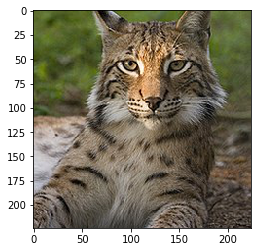

In [22]:
plt.imshow(to_img(IMAGEURL))

In [23]:
jsonimg = img_url_to_json(IMAGEURL)
jsonimg[:100]

'{"input": {"image": "\\"iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AAABJGlDQ1BJQ0MgUHJvZmlsZQAAeJxjY'

In [24]:
headers = {"content-type": "application/json"}
%time r = requests.post('http://0.0.0.0:80/score', data=jsonimg, headers=headers)
print(r)
r.json()

CPU times: user 2.66 ms, sys: 5.31 ms, total: 7.97 ms
Wall time: 4.55 s
<Response [200]>


[{'image': [['n02127052', 'lynx', '0.9816483'],
   ['n02128385', 'leopard', '0.0077441484'],
   ['n02123159', 'tiger_cat', '0.003686138']]},
 'Computed in 4534.81 ms']

In [25]:
images = (
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Harmony_of_the_Seas_%28ship%2C_2016%29_001.jpg/1920px-Harmony_of_the_Seas_%28ship%2C_2016%29_001.jpg",
    "http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/",
    "https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg",
    "http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg",
)

In [26]:
url = "http://0.0.0.0:80/score"
results = [
    requests.post(url, data=img_url_to_json(img), headers=headers) for img in images
]

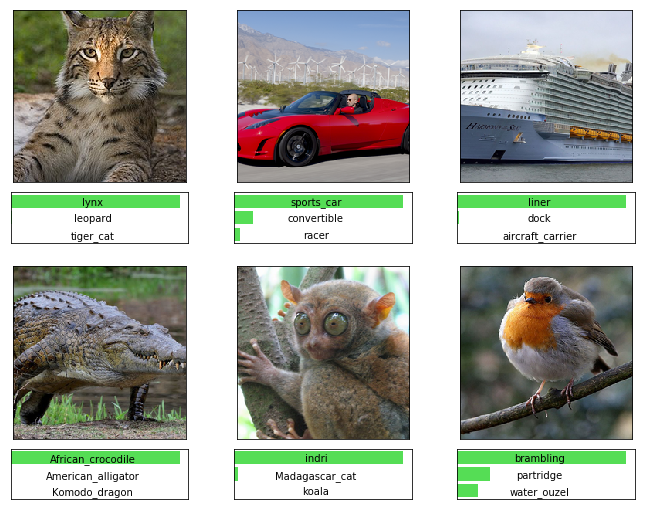

In [27]:
plot_predictions(images, results)

In [28]:
image_data = list(map(img_url_to_json, images)) # Retrieve the images and data

In [29]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(url, data=img, headers=headers)
    timer_results.append(res.best)

In [30]:
timer_results

[0.08174494775012135,
 0.07980109136551619,
 0.07854228727519512,
 0.08096609506756067,
 0.07893699845299125,
 0.07853729706257581]

In [31]:
print("Average time taken: {0:4.2f} ms".format(10 ** 3 * np.mean(timer_results)))

Average time taken: 79.75 ms


In [32]:
container.stop()

In [ ]:
# remove stopped container
!docker system prune -f

We can now move on to [Create kubenetes cluster and deploy web service](04_DeployOnAKS.ipynb) with the image we just built.